In [1]:
import random
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# PART 1

ONE DIMENSIONAL DIRECT METHODS OF OPTIMIZATION

In [2]:
def exhaustive_search(f, x_min=0, x_max=1, eps=0.001):
    n = (x_max - x_min) / eps
    f_min = None
    x_res = None
    f_num = 0
    iter_num = 0
    for k in tqdm(range(int(n))):
        iter_num += 1
        x = x_min + k * eps
        f_num += 1
        f_res = f(x)
        if f_min is None or f_res < f_min:
            f_min = f_res
            x_res = x
    return f_num, iter_num

def dichotomy(f, x_min=0, x_max=1, eps=0.001, delta=0.5):
    delta *= eps
    f_num = 0
    iter_num = 0
    pbar = tqdm()
    while x_min + eps < x_max:
        iter_num += 1
        avg = (x_min + x_max) / 2
        x1, x2 = avg - delta, avg + delta
        f_num += 2
        f1, f2 = map(f, (x1, x2))
        if f1 <= f2:
            x_max = x1
        else:
            x_min = x2
        pbar.update(1)
    pbar.close()
    return f_num, iter_num

def gold_section(f, x_min=0, x_max=1, eps=0.001):
    gold_ratio = (3 - 5 ** 0.5) / 2
    f_num = 0
    iter_num = 0
    pbar = tqdm()
    while x_min + eps < x_max:
        iter_num += 1
        term = (x_max - x_min) * gold_ratio
        x1, x2 = x_min + term, x_max - term
        f_num += 2
        f1, f2 = map(f, (x1, x2))
        if f1 <= f2:
            x_max = x1
        else:
            x_min = x2
        pbar.update(1)
    pbar.close()
    return f_num, iter_num

In [3]:
formulas = (lambda x: x ** 3, lambda x: abs(x - 0.2), lambda x: x * math.sin(1 / x))
domains = ((0, 1), (0, 1), (0.01, 1))

In [4]:
iter_nums, f_nums = [], []

for i, (f, d) in enumerate(zip(formulas, domains)):
    for method_func in (exhaustive_search, dichotomy, gold_section):
        f_num, iter_num = method_func(f, *d)
        iter_nums.append(iter_num)
        f_nums.append(f_num)
        
f_repr = ['x ** 3', 'abs(x - 0.2)', 'x * sin(1/x)']
pd.DataFrame({'Formula': [f_repr[x // 3] for x in range(len(formulas) * 3)], 'Method': ['Exhaustive Search', 'Dichotomy', 'Gold Section'] * len(formulas), 'Number of iterations': iter_nums, 'Number of function calls': f_nums})

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/990 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Formula,Method,Number of iterations,Number of function calls
0,x ** 3,Exhaustive Search,1000,1000
1,x ** 3,Dichotomy,9,18
2,x ** 3,Gold Section,8,16
3,abs(x - 0.2),Exhaustive Search,1000,1000
4,abs(x - 0.2),Dichotomy,9,18
5,abs(x - 0.2),Gold Section,8,16
6,x * sin(1/x),Exhaustive Search,990,990
7,x * sin(1/x),Dichotomy,9,18
8,x * sin(1/x),Gold Section,8,16


# PART 2

MULTIDIMENSIONAL DIRECT METHODS OF OPTIMIZATION

In [2]:
def generate_data(seed=None):
    random.seed(seed)
    alpha = random.random()
    betta = random.random()
    xs = np.linspace(0, 1, 101)
    ys = [alpha * x + betta + random.random() for x in xs]
    return xs, ys

def score_func(f, a, b, xs, ys):
    return sum((f(x, a, b) - y) ** 2 for x, y in zip(xs, ys))

def exhaustive_search(f, xs, ys, x_min=0, x_max=1, eps=0.001, seed=None):
    f_min = a_res = b_res = None
    domain = np.linspace(x_min, x_max, math.ceil(1 / eps))
    f_num = iter_num = 0
    pbar = tqdm()
    for a in domain:
        for b in domain:
            pbar.update()
            iter_num += 1
            f_num += 1
            f_res = score_func(f, a, b, xs, ys)
            if f_min is None or f_res < f_min:
                f_min, a_res, b_res = f_res, a, b
    pbar.close()
    return f_num, iter_num, f_min, (a_res, b_res)

def gauss(f, xs, ys, x_min=0, x_max=1, eps=0.001, seed=None):
    f_num = 1
    iter_num = 0
    a_prev = b_prev = f_prev = None
    random.seed(seed)
    a_cur, b_cur = random.random() * (x_max - x_min) + x_min, random.random() * (x_max - x_min) + x_min
    f_cur = score_func(f, a_cur, b_cur, xs, ys)
    domain = np.linspace(x_min, x_max, math.ceil(1 / eps))
    pbar = tqdm()
    a_frozen = False
    while not iter_num or not (((a_cur - a_prev) ** 2 + (b_cur - b_prev) ** 2) ** 0.5 < eps or abs(f_cur - f_prev) < eps):
        f_min = None
        if a_frozen:
            for b in domain:
                iter_num += 1
                f_num += 1
                f_res = score_func(f, a_cur, b, xs, ys)
                if f_min is None or f_min > f_res:
                    f_min = f_res
                    b_res = b
            a_cur, b_cur, a_prev, b_prev, f_cur, f_prev = a_cur, b_res, a_cur, b_cur, f_min, f_cur
        else:
            for a in domain:
                iter_num += 1
                f_num += 1
                f_res = score_func(f, a, b_cur, xs, ys)
                if f_min is None or f_min > f_res:
                    f_min = f_res
                    a_res = a
            a_cur, b_cur, a_prev, b_prev, f_cur, f_prev = a_res, b_cur, a_cur, b_cur, f_min, f_cur
        a_frozen ^= 1
        pbar.update()
    pbar.close()
    return f_num, iter_num, f_cur, (a_cur, b_cur)

def Nelder_Mead(f, xs, ys, x_min=0, x_max=1, eps=0.001, seed=None):
    alpha = 1  # reflection coefficient
    betta = 0.5  # shrinking coefficient
    gamma = 2  # expansion coefficient
    random.seed(seed)
    points = [[random.random() * (x_max - x_min) + x_min for _ in range(2)] for _ in range(3)]
    for i in range(3):
        points[i].insert(0, score_func(f, *points[i], xs, ys))
    points = np.array(points)
    f_num = 3
    iter_num = 0
    pbar = tqdm()
    while np.std([(p[1] ** 2 + p[2] ** 2) ** 0.5 for p in points]) >= eps:
        iter_num += 1
        points = points[points[:, 0].argsort(), :]
        c = np.mean(points[:2], axis=1)[1:]
        r = (1 + alpha) * c - alpha * points[2][1:]  # reflection
        fr = score_func(f, *r, xs, ys)
        f_num += 1
        if fr < points[0][0]:
            e = (1 - gamma) * c + gamma * r
            fe = score_func(f, *e, xs, ys)  # expansion
            f_num += 1
            if fe < fr:
                points[2] = [fe, *e]
            else:
                points[2] = [fr, *r]
            pbar.update()
            continue
        elif fr < points[1][0]:
            points[2] = [fr, *r]
            pbar.update()
            continue
        elif fr < points[2][0]:
            fr, r, points[2] = points[2][0], points[2][1:], [fr, *r]
        s = betta * points[2][1:] + (1 - betta) * c
        fs = score_func(f, *s, xs, ys)  # shrinking
        f_num += 1
        if fs < points[2][0]:
            points[2] = [fs, *s]
        else:
            for i in range(1, 3):
                points[i][1:] = (points[0][1:] + points[i][1:]) / 2
                points[i][0] = score_func(f, *points[i][1:], xs, ys)
                f_num += 1
        pbar.update()
    pbar.close()
    
    return f_num, iter_num, points[0][0], points[0][1:]
            
formulas = (lambda x, a, b: a * x + b, lambda x, a, b: a / (1 + b * x))

In [13]:
seed = 1001
xs, ys = generate_data(seed)
x_min, x_max, eps = 0, 1, 0.001
f_nums, iter_nums, f_mins, coeffs = [], [], [], []
for method in (exhaustive_search, gauss, Nelder_Mead):
    for formula in formulas:
        f_num, iter_num, f_min, coeff = method(formula, xs, ys, x_min=x_min, x_max=x_max, eps=eps, seed=seed)
        f_nums.append(f_num)
        iter_nums.append(iter_num)
        f_mins.append(f_min)
        coeffs.append(coeff)
        
methods_repr = ['Exhaustive search', 'Gauss', 'Nelder Mead']
formula_repr = ['a * x + b', 'a / (1 + b * x)']
pd.DataFrame({'Method': [methods_repr[x // 2] for x in range(6)], 'Formula': formula_repr * 3, 'Number of iterations': iter_nums,\
             'Number of function calls': f_nums, 'Found F minimum': f_mins})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Method,Formula,Number of iterations,Number of function calls,Found F minimum
0,Exhaustive search,a * x + b,1000000,1000000,9.562289
1,Exhaustive search,a / (1 + b * x),1000000,1000000,14.093677
2,Gauss,a * x + b,21000,21001,9.564772
3,Gauss,a / (1 + b * x),4000,4001,14.093677
4,Nelder Mead,a * x + b,9,39,10.304735
5,Nelder Mead,a / (1 + b * x),9,39,17.840468


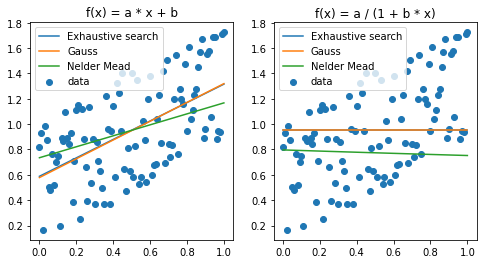

In [16]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
x_domain = np.linspace(0, 1)
for i in range(2):
    axs[i].set_title('f(x) = ' + formula_repr[i])
    axs[i].scatter(x=xs, y=ys)
    for j in range(3):
        a, b = coeffs[j * 2 + i]
        axs[i].plot(x_domain, [formulas[i](x, a, b) for x in x_domain])
    axs[i].legend(list(methods_repr) + ['data'])

In [17]:
pd.DataFrame({'Method': [methods_repr[x // 2] for x in range(6)], 'Formula': formula_repr * 3, 'Number of iterations': iter_nums,\
             'Number of function calls': f_nums, 'Found F minimum': f_mins, 'a': [x[0] for x in coeffs], 'b': [x[1] for x in coeffs]}).to_csv('lab2_results.csv', index=False)